In [1]:
import pandas as pd

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [3]:
import seaborn as sns

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [6]:
# Параметры отображения графиков:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 11})

# Загрузка и предварительная обработка данных

Источник данных: https://archive.ics.uci.edu/ml/datasets/Parking+Birmingham

In [7]:
file_name = 'Birmingham_car_parks.csv'

In [8]:
data = pd.read_csv(file_name, parse_dates=['LastUpdated'])

In [9]:
data.head()

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48


In [10]:
data.shape

(35717, 4)

In [11]:
data.dtypes

SystemCodeNumber            object
Capacity                     int64
Occupancy                    int64
LastUpdated         datetime64[ns]
dtype: object

In [12]:
data.isna().sum()

SystemCodeNumber    0
Capacity            0
Occupancy           0
LastUpdated         0
dtype: int64

In [13]:
# Количество парковок с разными ID:
len(data.SystemCodeNumber.unique())

30

In [14]:
data.describe()

,Capacity,Occupancy
count,35717.000000,35717.000000
mean,1397.550130,642.228911
std,1179.326833,656.955535
min,220.000000,-8.000000
25%,500.000000,210.000000
50%,849.000000,446.000000
75%,2009.000000,798.000000
max,4675.000000,4327.000000


In [15]:
# Месяц:
data['Month'] = data.LastUpdated.dt.month

In [16]:
# Время суток:
data['Hour'] = data.LastUpdated.dt.hour

In [17]:
# Заполняемость парковки в процентах от общей вместимости:
data['Occupancy_pc'] = data.Occupancy / data.Capacity

In [18]:
data.head()

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,Month,Hour,Occupancy_pc
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42,10,7,0.105719
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42,10,8,0.110919
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42,10,8,0.138648
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46,10,9,0.185442
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48,10,9,0.259965


In [19]:
# В некоторых случаях фактическое количество машин незначительно превышает вместимость:
data[data.Occupancy_pc > 1]

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,Month,Hour,Occupancy_pc
1396,BHMBCCPST01,317,320,2016-10-08 14:03:38,10,14,1.009464
1613,BHMBCCPST01,317,318,2016-10-22 14:39:47,10,14,1.003155
3548,BHMBCCSNH01,863,865,2016-11-28 11:01:30,11,11,1.002317
3549,BHMBCCSNH01,863,866,2016-11-28 11:32:28,11,11,1.003476
3583,BHMBCCSNH01,863,864,2016-11-30 10:28:38,11,10,1.001159
...,...,...,...,...,...,...,...
7542,BHMBRCBRG02,1194,1198,2016-12-18 14:03:26,12,14,1.003350
12732,BHMMBMMBX01,687,688,2016-12-19 13:03:30,12,13,1.001456
14796,BHMNCPLDH01,720,723,2016-11-16 11:00:51,11,11,1.004167
15350,BHMNCPNHS01,500,501,2016-10-04 10:26:49,10,10,1.002000


In [20]:
# В некоторых строках заполняемость отрицательная:
data[data.Occupancy < 0]

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,Month,Hour,Occupancy_pc
23889,NIA North,480,-3,2016-10-16 15:57:16,10,15,-0.006250
23890,NIA North,480,-3,2016-10-16 16:31:17,10,16,-0.006250
23906,NIA North,480,-1,2016-10-18 15:27:59,10,15,-0.002083
23919,NIA North,480,-8,2016-10-28 13:02:43,10,13,-0.016667
23924,NIA North,480,-1,2016-10-28 15:29:41,10,15,-0.002083
23925,NIA North,480,-4,2016-10-28 16:02:40,10,16,-0.008333
23926,NIA North,480,-1,2016-10-28 16:29:42,10,16,-0.002083
23937,NIA North,480,-2,2016-10-29 12:59:51,10,12,-0.004167
23944,NIA North,480,-1,2016-10-29 16:26:53,10,16,-0.002083
23997,NIA North,480,-3,2016-11-10 16:00:15,11,16,-0.006250


In [21]:
def occupancy_corrector(rate: float) -> float:
    """Функция исправляет технические ошибки в уровне
    заполняемости парковки, отрицательные значения
    заменяет на 0, значения > 1 заменяет на 1."""
    if rate < 0:
        rate = 0
    elif rate > 1:
        rate = 1
    return rate

In [22]:
# Исправляем технические ошибки в данных:
data.Occupancy_pc = data.Occupancy_pc.apply(occupancy_corrector)

In [23]:
data.describe()

,Capacity,Occupancy,Month,Hour,Occupancy_pc
count,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000
mean,1397.550130,642.228911,10.881205,11.787524,0.493150
std,1179.326833,656.955535,0.752064,2.617731,0.270985
min,220.000000,-8.000000,10.000000,7.000000,0.000000
25%,500.000000,210.000000,10.000000,10.000000,0.255881
50%,849.000000,446.000000,11.000000,12.000000,0.471872
75%,2009.000000,798.000000,11.000000,14.000000,0.717504
max,4675.000000,4327.000000,12.000000,16.000000,1.000000


# Визуализация данных

Text(0, 0.5, 'Заполняемость, в долях от 1')

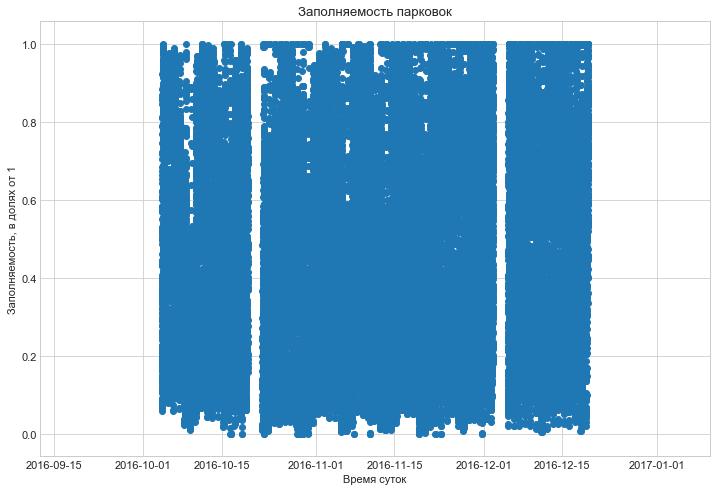

In [24]:
plt.scatter(data.LastUpdated, data.Occupancy_pc)
plt.title('Заполняемость парковок')
plt.xlabel('Время суток')
plt.ylabel('Заполняемость, в долях от 1')

Общий график распределения заполняемости парковок по временной шкале неинформативен, т.к. не позволяет установить зависимость рассматриваемого параметра от характеристик парковки и внешних факторов. Целесообразно проанализировать зависимость спроса на парковочные места от основных характерик, влияющих на спрос:
- время суток;
- время года;
- размер (вместимость) парковки;
- расположение парковки (относительно центра города, зон деловой активности и туризма, транспортных узлов).

In [25]:
# Средняя заполняемость по времени суток:
hourly_data = data.groupby('Hour')['Occupancy_pc'].mean()

Text(0, 0.5, 'Заполняемость, в долях от 1')

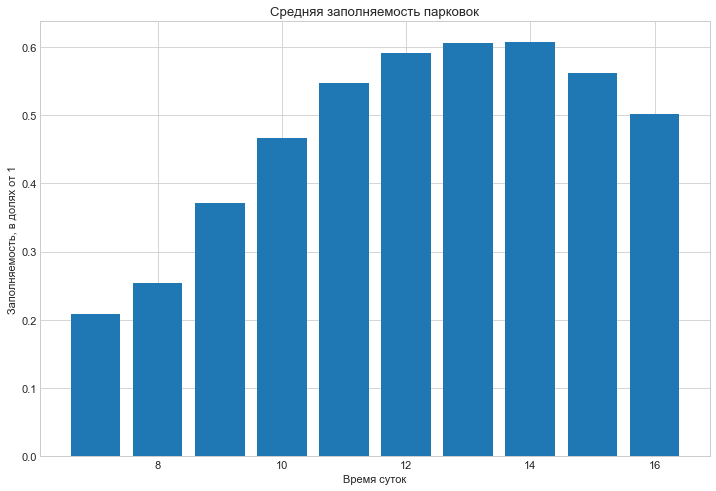

In [26]:
plt.bar(hourly_data.index, hourly_data.values)
plt.title('Средняя заполняемость парковок')
plt.xlabel('Время суток')
plt.ylabel('Заполняемость, в долях от 1')

В исходном файле собраны данные о заполняемости парковок в промежутке с 7 утра до 16.00. Пик спроса приходится на временной интервал с 12.00 до 14.00 (средняя заполняемость - около 60%). Наиболее низкая заполняемость наблюдается в утренние часы (7.00 - 8.00).

In [27]:
# Средняя заполняемость по месяцам:
monthly_data = data.groupby('Month')['Occupancy_pc'].mean()

Text(0, 0.5, 'Заполняемость, в долях от 1')

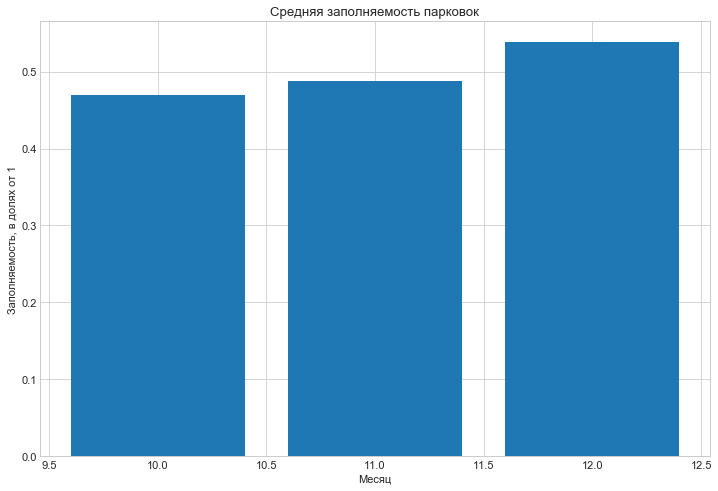

In [28]:
plt.bar(monthly_data.index, monthly_data.values)
plt.title('Средняя заполняемость парковок')
plt.xlabel('Месяц')
plt.ylabel('Заполняемость, в долях от 1')

In [29]:
data.Month.value_counts()

11    15012
10    12474
12     8231
Name: Month, dtype: int64

По какой-то необъяснимой причине в исходных данных собраны показатели только за 3 месяца. Однако даже по этим усеченным данным видно, что спрос на парковочные места в течение года неодинаков и увеличивается в декабре по сравнению с предшествующими месяцами.

In [30]:
# Делим парковки на группы по вместимости:
data['Size'] = pd.cut(data.Capacity, bins=[200, 500, 1000, 2000, 3000, 4000, 5000],
                      labels=['200-500 lots', '500-1000 lots', '1000-2000 lots',
                              '2000-3000 lots', '3000-4000 lots', '4000-5000 lots'])

In [31]:
# Средняя заполняемость в зависимости от вместимости парковки:
size_data = data.groupby('Size')['Occupancy_pc'].mean()

Text(0, 0.5, 'Заполняемость, в долях от 1')

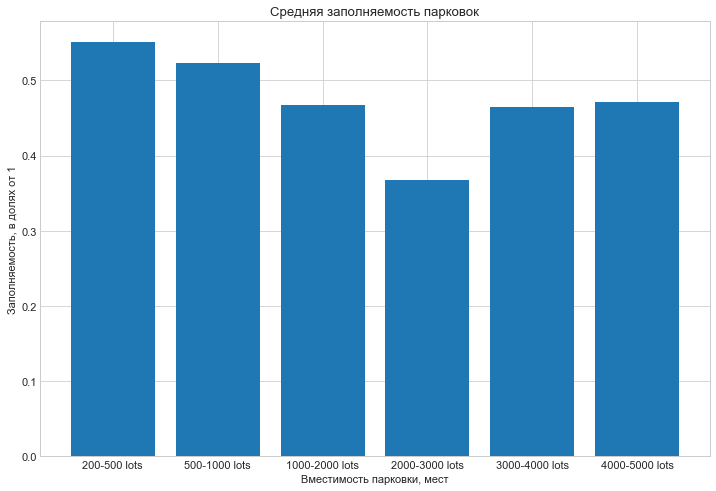

In [32]:
plt.bar(size_data.index, size_data.values)
plt.title('Средняя заполняемость парковок')
plt.xlabel('Вместимость парковки, мест')
plt.ylabel('Заполняемость, в долях от 1')

Наиболее высокая заполняемость характерна для небольших парковок вместимостью до 500 мест. По мере увеличения вместимости парковки показатели заполняемости преимущественно снижаются. Наиболее крупные парковки на 3000-5000 мест более востребованы, чем парковки на 2000-3000 мест, что может объясняться их более выгодным расположением (вблизи аэропорта, транспортных узлов и проч.).

In [33]:
# Средняя заполняемость в зависимости от местоположения:
zone_data = data.groupby('SystemCodeNumber')['Occupancy_pc'].mean()

Text(0, 0.5, 'Заполняемость, в долях от 1')

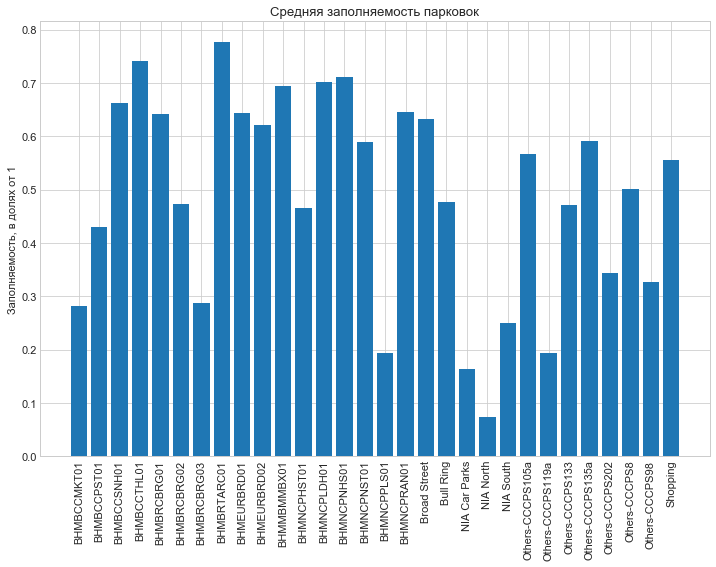

In [34]:
plt.bar(zone_data.index, zone_data.values)
plt.title('Средняя заполняемость парковок')
plt.xticks(rotation=90)
plt.ylabel('Заполняемость, в долях от 1')

График подтверждает, что расположение парковки существенно влияет на спрос. Парковки, наименования (идентификаторы) которых содержат схожие символы, имеют разную заполняемость, поэтому нецелесообразно объединять их в какие-то группы. Для характеристики местоположения будут использоваться исходные 30 наименований в столбце 'SystemCodeNumber'.

Text(0.5, 1, 'Матрица корреляции')

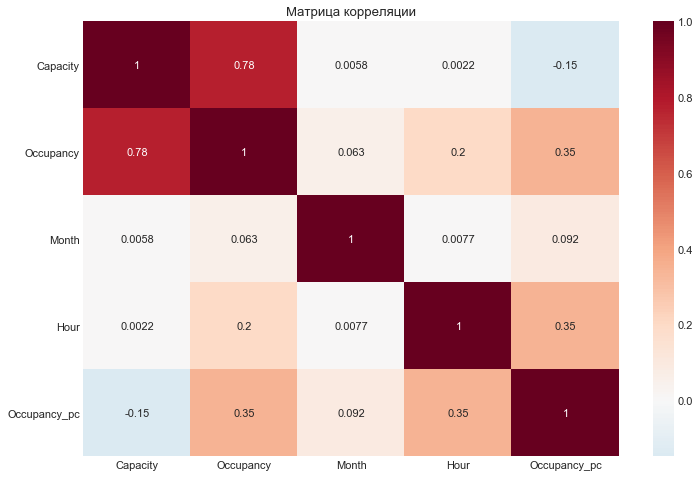

In [35]:
correlation = data.corr()
ax = sns.heatmap(correlation, center=0, annot=True, cmap='RdBu_r')
l, r = ax.get_ylim()
ax.set_ylim(l + 0.5, r - 0.5)
plt.yticks(rotation=0)
plt.title('Матрица корреляции')

# Подготовка данных для модели

In [36]:
# Прогнозируемые значения:
y = data.Occupancy_pc

In [37]:
# Входные параметры:
X = data[['SystemCodeNumber', 'Capacity', 'Month', 'Hour']]

In [38]:
# Списки числовых и категорийных параметров:
num_cols = X.select_dtypes(include='number').columns
cat_cols = X.select_dtypes(exclude='number').columns

In [39]:
# Преобразование данных (кодирование категорийных столбцов,
# нормирование числовых значений):
ct = make_column_transformer(
    (OneHotEncoder(), cat_cols),
    (StandardScaler(), num_cols),
    remainder='passthrough')

In [40]:
# Нормирование данных:
X_processed = ct.fit_transform(X)

# Подбор регрессионной модели

In [41]:
# Инструмент для разбиения данных на группы при кросс-валидации:
kf = KFold(10, shuffle=True)

In [42]:
# Список рассматриваемых моделей:
models = [('Decision Tree', DecisionTreeRegressor()),
          ('Gradient Boosting', GradientBoostingRegressor()),
          ('Random Forest', RandomForestRegressor(n_estimators=100))]

In [43]:
# Параметр R2 при кросс-валидации для рассматриваемых моделей:
for name, model in models:
    rmodel = model
    r2 = cross_val_score(rmodel, X_processed, y, cv=kf, scoring='r2', n_jobs=-1).mean()
    print(f'{name}: R2 = {r2}')

Decision Tree: R2 = 0.6830121911910897
Gradient Boosting: R2 = 0.6476661126318624
Random Forest: R2 = 0.6825828341459588


In [44]:
# Параметр MAE при кросс-валидации для рассматриваемых моделей:
for name, model in models:
    rmodel = model
    MAE = abs(cross_val_score(rmodel, X_processed, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1).mean())
    print(f'{name}: MAE = {MAE}')

Decision Tree: MAE = 0.10701758844158053
Gradient Boosting: MAE = 0.12265896119227204
Random Forest: MAE = 0.10704371711463004


#### Выводы
- Среди рассматриваемых регрессоров наиболее высокую точность показывают модели на основе деревьев решений (Decision Tree и Random Forest).
- Коэффициент детерминации R2 для всех моделей составляет менее 0.7. Это свидетельствует о том, что регрессоры не в достаточной степени учитывают факторы, влияющие на изменение прогнозируемого показателя. Потенциально для улучшения моделей можно добавить дополнительные параметры, описывающие локальные особенности расположения парковок, влияние выходных и праздничных дней на их заполняемость.
- Средняя ошибка наиболее успешных регрессионных моделей составляет 10.7%.